# **Решение задачи коммивояжёра с помощью алгоритма имитации отжига**

## ***Все расчеты для данного ноутбука взяты из вспомогательного материала к вебинару "Решение оптимизационных задач неградиентными методами", youtube-канал Karpov.Courses. Ведущий вебинара Игорь Котенков.***

**Задача коммивояжёра** (или TSP от англ. Travelling salesman problem) — одна из самых известных задач комбинаторной оптимизации, заключающаяся в поиске самого выгодного маршрута, проходящего через указанные города хотя бы по одному разу с последующим возвратом в исходный город.

**Алгори́тм имита́ции о́тжига** (англ. Simulated annealing) — общий алгоритмический метод решения задачи глобальной оптимизации, особенно дискретной и комбинаторной оптимизации. Один из примеров методов Монте-Карло.

In [1]:
import numpy as np
import random
import copy
from tqdm import tqdm
from typing import List, Tuple
import matplotlib.pyplot as plt
%matplotlib inline

###Вспомогательные объекты и функции для задачи коммивояжера

In [2]:
class City:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y
        
    def __repr__(self) -> str:
        return "City(" + str(self.x) + "," + str(self.y) + ")"

In [3]:
class Dist:
    def __init__(self, route: List[City]):
        self.route = route
        self.l_distance = None
    

    def distance(self, city1: 'City', city2: 'City') -> float:
        # обычное Евклидово расстояние
        x_dis = abs(city1.x - city2.x)
        y_dis = abs(city1.y - city2.y)
        distance = ((x_dis ** 2) + (y_dis ** 2))**0.5
        return distance    
    
 
    def calc_distance(self) -> float:
        # считаем суммарное расстояние по всем дорогам, не забывая про дорогу к начальной точке
        if self.l_distance is None:
            path_distance = 0
            for i in range(0, len(self.route)):
                from_city = self.route[i]
                to_idx = (i+1) % len(self.route)
                to_city = self.route[to_idx]
                path_distance = path_distance + self.distance(from_city, to_city)
            self.l_distance = path_distance
        return self.l_distance

In [4]:
def create_random_route(city_list: List[City], seed = 0) -> List[City]:
    random.seed(seed)
    route = random.sample(city_list, len(city_list))
    return route

### Генерация "карты" для путешествий

In [5]:
NUM_CITIES = 15

np.random.seed(42)
cities_coords = np.random.rand(NUM_CITIES, 2) * 10

In [6]:
cities_coords[:7]

array([[3.74540119, 9.50714306],
       [7.31993942, 5.98658484],
       [1.5601864 , 1.5599452 ],
       [0.58083612, 8.66176146],
       [6.01115012, 7.08072578],
       [0.20584494, 9.69909852],
       [8.32442641, 2.12339111]])

In [7]:
city_list = [City(x, y) for x, y in cities_coords]

In [8]:
city_list[:7]

[City(3.745401188473625,9.50714306409916),
 City(7.319939418114051,5.986584841970366),
 City(1.5601864044243652,1.5599452033620265),
 City(0.5808361216819946,8.661761457749352),
 City(6.011150117432088,7.080725777960454),
 City(0.20584494295802447,9.699098521619943),
 City(8.324426408004218,2.1233911067827616)]

In [9]:
random_route = create_random_route(city_list)

In [10]:
def plot_TSP(route: List[City]):
    x, y = [], []
    for city in route:
        x.append(city.x)
        y.append(city.y)
    
    
    fig = plt.figure(figsize=(5,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.scatter(x, y,  color='b', zorder=5)

    arrow_scale = float(max(x))/float(75)

    ax.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = arrow_scale, 
            color ='g', length_includes_head=True, zorder=10)
    for i in range(0,len(x)-1):
        ax.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = arrow_scale,
                color = 'g', length_includes_head = True, zorder=10)

    plt.xlim(-1, max(x)+1)
    plt.ylim(-1, max(y)+1)
    fitess = Dist(route).calc_distance()
    plt.title(f'Distance: {round(fitess, 2)}')
    plt.xlabel('Координаты города, X')
    plt.ylabel('Координаты города, Y')
    plt.show()

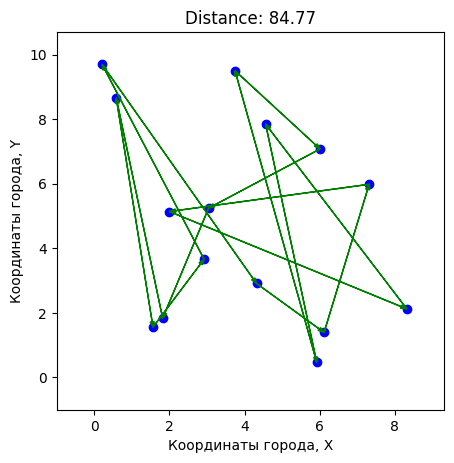

In [11]:
plot_TSP(random_route)

### Алгоритм имитации отжига

In [12]:
def do_transition(prob: float) -> bool:
    rand_value = random.random() # ~Uniform(0, 1)
    return rand_value <= prob


def transition_prob(func_val_diff: float, temp: float):
    return np.e ** (-func_val_diff/temp)


def calc_temp(start_temp: float, num_iter: int, cur_iter: int) -> float:
    return start_temp * (1 - cur_iter/num_iter)


def generate_candidate_route(route: List[City]) -> List[City]:
    route_len = len(route)
    
    first_city_idx = random.randint(0, route_len-1)
    second_city_idx = random.randint(0, route_len-1)
    if first_city_idx > second_city_idx:
        first_city_idx, second_city_idx = second_city_idx, first_city_idx

    # 1 2 3 4 -> 1 4 3 2
    new_route = copy.deepcopy(route)
    new_route[first_city_idx : second_city_idx] = reversed(new_route[first_city_idx : second_city_idx]) 
    return new_route

In [13]:
def optimize_with_annealing(route: List[City], num_iter=10000, start_temp=30, plot_history=True) -> List[City]:
    cur_route_fitness = Dist(route)
    
    history = []
    
    for cur_iter in tqdm(range(num_iter)):
        # на каждой итерации генерируем кандидата для расмотрения
        candidate_route = generate_candidate_route(route)
        candidate_fitness = Dist(candidate_route)
        # и считаем значение функции для кандидата и текущего объекта
        cur_route_dist = cur_route_fitness.calc_distance()
        candidate_dist = candidate_fitness.calc_distance()
        
        history.append(cur_route_dist)
        # если текущая дорога длинее 
        if cur_route_dist > candidate_dist:
            # делаем переход (с вероятностью равной 1) в это состояние
            route = candidate_route
            cur_route_fitness = candidate_fitness
        else:
            # иначе рассчитываем температуру
            cur_iter_temp = calc_temp(start_temp, num_iter, cur_iter)
            func_val_diff = candidate_dist - cur_route_dist
            # и вероятность перехода в новое состояние (которое хуже с точки зрения дистанции)
            cur_iter_transition_prob = transition_prob(func_val_diff, cur_iter_temp)
            # бросаем монетку
            make_transition = do_transition(cur_iter_transition_prob)
            
            if make_transition:
                # осуществляем переход, если случайная величина так решила
                route = candidate_route
                cur_route_fitness = candidate_fitness
                
    if plot_history:
        fig = plt.figure(figsize=(5,5), dpi=100)
        ax = fig.add_subplot(111)
        ax.plot(history)
        plt.title('Значение дистанции в зависимости от номера итерации')
        plt.xlabel('Номер итерации')
        plt.ylabel('Проходимое торговцем расстояние');
    return route


100%|██████████| 10000/10000 [00:02<00:00, 4336.64it/s]


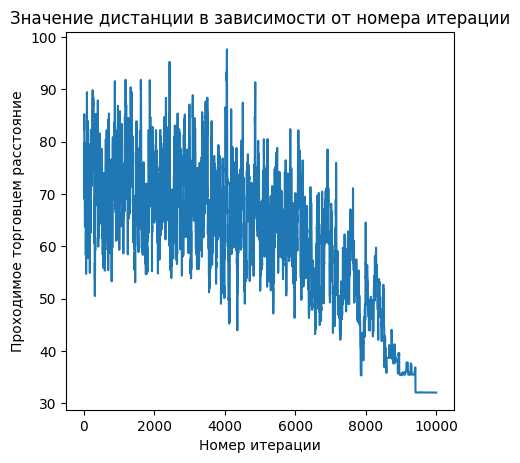

In [14]:
random.seed(42)
best_route_annealing = optimize_with_annealing(random_route, num_iter=10000, start_temp=10, plot_history=True)

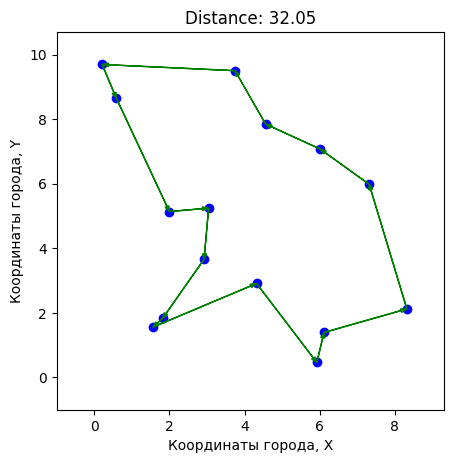

In [15]:
plot_TSP(best_route_annealing)